<a href="https://colab.research.google.com/github/yomyaykya/yomyay/blob/master/mmolab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
%matplotlib inline
sns.set(style="ticks")

In [ ]:
data_loaded = pd.read_csv('solar.csv', sep=",")

In [ ]:
data_loaded.head()

,Catalog Number,Unnamed: 1,Time,Delta,Lunationnumber,Sarosnumber,Unnamed: 6,Gamma,Eclipsemagnitude,Unnamed: 9,Unnamed: 10,Sunaltitude,Sunazimuth,PathWidth (km),Central Duration,UNIXTime,WindDirection(Degrees),TimeSunRise,TimeSunSet
0,1.0,NaN,3:14:51,46438.0,49456.0,5.0,NaN,0.2701,1.0733,NaN,NaN,74.0,344.0,247.0,0:06:37,1475229326,177.39,6:13:00,18:13:00
1,2.0,NaN,23:45:23,46426.0,49457.0,10.0,NaN,0.2702,0.9382,NaN,NaN,76.0,21.0,248.0,0:06:38,1475229023,176.78,6:13:00,18:13:00
2,3.0,NaN,18:09:16,46415.0,49458.0,15.0,NaN,0.2703,1.0284,NaN,NaN,60.0,151.0,249.0,0:06:37,1475228726,158.75,6:13:00,18:13:00
3,4.0,NaN,5:57:03,46403.0,49459.0,20.0,NaN,0.2704,0.9806,NaN,NaN,25.0,74.0,250.0,0:06:37,1475228421,137.71,6:13:00,18:13:00
4,5.0,NaN,13:19:56,46393.0,49460.0,-13.0,NaN,0.2705,0.1611,NaN,NaN,0.0,281.0,251.0,0:06:38,1475228124,104.95,6:13:00,18:13:00


In [ ]:
data_loaded.shape

(32686, 19)

In [ ]:

data_features = list(zip(
[i for i in data_loaded.columns],
zip(
    #типы колонок
    [str(i) for i in data_loaded.dtypes],
    #проверка, есть ли пропущенные значения
    [i for i in data_loaded.isnull().sum()]
)))
data_features

[('Catalog Number', ('float64', 20788)),
 ('Unnamed: 1', ('float64', 32686)),
 ('Time', ('object', 20788)),
 ('Delta', ('float64', 20788)),
 ('Lunationnumber', ('float64', 20788)),
 ('Sarosnumber', ('float64', 20788)),
 ('Unnamed: 6', ('float64', 32686)),
 ('Gamma', ('float64', 20788)),
 ('Eclipsemagnitude', ('float64', 20788)),
 ('Unnamed: 9', ('float64', 32686)),
 ('Unnamed: 10', ('float64', 32686)),
 ('Sunaltitude', ('float64', 20788)),
 ('Sunazimuth', ('float64', 20788)),
 ('PathWidth (km)', ('float64', 20835)),
 ('Central Duration', ('object', 19672)),
 ('UNIXTime', ('int64', 0)),
 ('WindDirection(Degrees)', ('float64', 0)),
 ('TimeSunRise', ('object', 0)),
 ('TimeSunSet', ('object', 0))]

# **Устранение пропусков в данных**

1.   **Удаление пропущенных значений**



In [ ]:
cols_with_na = ['Time', 'Delta', 'Lunationnumber', 'Sarosnumber', 'Gamma', 'Sunazimuth', 'UNIXTime']
data_drop = data_loaded[cols_with_na].dropna()
data_drop.shape

(11898, 7)

In [ ]:
def plot_hist_diff(old_ds, new_ds, cols):
    """
    Разница между распределениями до и после устранения пропусков
    """
    for c in cols:   
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.title.set_text('Поле - ' + str(c))
        old_ds[c].hist(bins=50, ax=ax, density=True, color='green')
        new_ds[c].hist(bins=50, ax=ax, color='blue', density=True, alpha=0.5)
        plt.show()

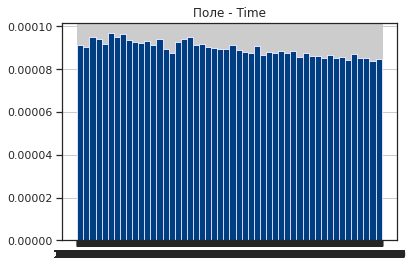

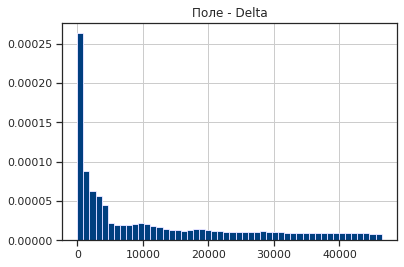

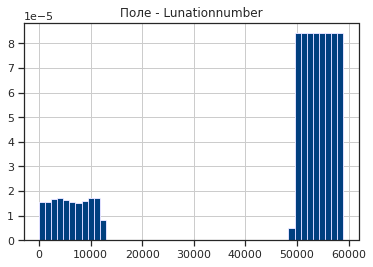

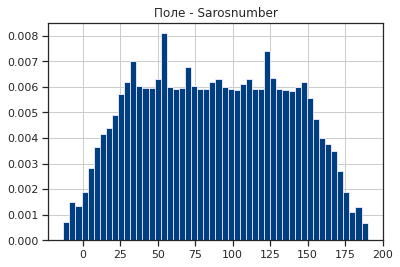

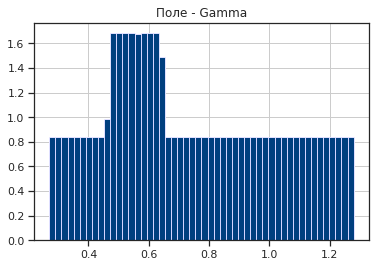

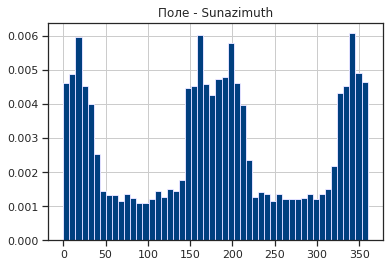

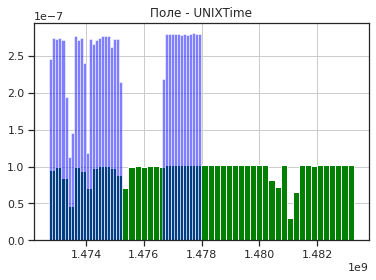

In [ ]:
plot_hist_diff(data_loaded, data_drop, cols_with_na)

2.   **Заполнение значений для одного признака**



In [ ]:
def impute_column(dataset, column, strategy_param, fill_value_param=None):
    """
    Заполнение пропусков в одном признаке
    """
    temp_data = dataset[[column]].values
    size = temp_data.shape[0]
    
    indicator = MissingIndicator()
    mask_missing_values_only = indicator.fit_transform(temp_data)
    
    imputer = SimpleImputer(strategy=strategy_param, 
                            fill_value=fill_value_param)
    all_data = imputer.fit_transform(temp_data)
    
    missed_data = temp_data[mask_missing_values_only]
    filled_data = all_data[mask_missing_values_only]
    
    return all_data.reshape((size,)), filled_data, missed_data

In [ ]:
#Заполнение показателем центра распределения
all_data, filled_data, missed_data = impute_column(data_loaded, 'UNIXTime', 'mean')
all_data

array([1.47522933e+09, 1.47522902e+09, 1.47522873e+09, ...,
       1.48058700e+09, 1.48058670e+09, 1.48058640e+09])

In [ ]:
data_loaded['UNIXTime']

0        1475229326
1        1475229023
2        1475228726
3        1475228421
4        1475228124
            ...    
32681    1480587604
32682    1480587301
32683    1480587001
32684    1480586702
32685    1480586402
Name: UNIXTime, Length: 32686, dtype: int64

In [ ]:
def research_impute_numeric_column(dataset, num_column, const_value=None):
    strategy_params = ['mean', 'median', 'most_frequent', 'constant']
    strategy_params_names = ['Среднее', 'Медиана', 'Мода']
    strategy_params_names.append('Константа = ' + str(const_value))
    
    original_temp_data = dataset[[num_column]].values
    size = original_temp_data.shape[0]
    original_data = original_temp_data.reshape((size,))
    
    new_df = pd.DataFrame({'Исходные данные':original_data})
       
    for i in range(len(strategy_params)):
        strategy = strategy_params[i]
        col_name = strategy_params_names[i]
        if (strategy!='constant') or (strategy == 'constant' and const_value!=None):
            if strategy == 'constant':
                temp_data, _, _ = impute_column(dataset, num_column, strategy, fill_value_param=const_value)
            else:
                temp_data, _, _ = impute_column(dataset, num_column, strategy)
            new_df[col_name] = temp_data
        
    sns.kdeplot(data=new_df)

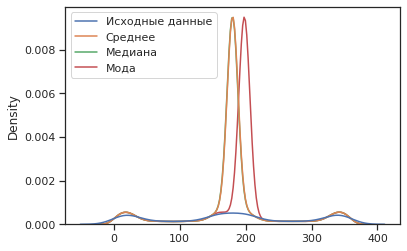

In [ ]:

#Сравнение заполнения различными показателями распределения
research_impute_numeric_column(data_loaded, 'Sunazimuth')

In [ ]:
#Заполнение наиболее распросттраненным значением категории
data_cat_cols = ['Sunazimuth', 'UNIXTime', 'Gamma']
data_cat_new = data_loaded[data_cat_cols].copy()

In [ ]:
data_cat_new

,Sunazimuth,UNIXTime,Gamma
0,344.0,1475229326,0.2701
1,21.0,1475229023,0.2702
2,151.0,1475228726,0.2703
3,74.0,1475228421,0.2704
4,281.0,1475228124,0.2705
...,...,...,...
32681,NaN,1480587604,NaN
32682,NaN,1480587301,NaN
32683,NaN,1480587001,NaN
32684,NaN,1480586702,NaN


In [ ]:
data_loaded.loc[data_loaded.loc[:, 'Sunazimuth'] == 'Новозыбков']

,Catalog Number,Unnamed: 1,Time,Delta,Lunationnumber,Sarosnumber,Unnamed: 6,Gamma,Eclipsemagnitude,Unnamed: 9,Unnamed: 10,Sunaltitude,Sunazimuth,PathWidth (km),Central Duration,UNIXTime,WindDirection(Degrees),TimeSunRise,TimeSunSet


In [ ]:
Sunazimuth_cat_new, _, _ = impute_column(data_cat_new, 'Sunazimuth', 'most_frequent')
UNIXTime_cat_new, _, _ = impute_column(data_cat_new, 'UNIXTime', 'most_frequent')
Gamma_cat_new, _, _ = impute_column(data_cat_new, 'Gamma', 'most_frequent')

In [ ]:

data_cat_new['Sunazimuth'] = Sunazimuth_cat_new
data_cat_new['UNIXTime'] = UNIXTime_cat_new
data_cat_new['Gamma'] = Gamma_cat_new

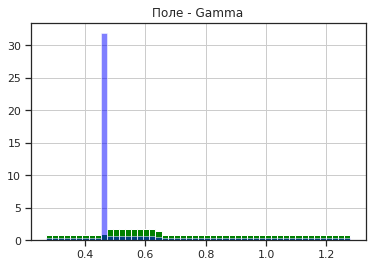

In [ ]:
plot_hist_diff(data_loaded, data_cat_new, ['Gamma'])

# **Кодирование категориальных признаков**

1.   **Label Encoding**



In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
data = data_loaded.copy()
data['Gamma']

0        0.2701
1        0.2702
2        0.2703
3        0.2704
4        0.2705
          ...  
32681       NaN
32682       NaN
32683       NaN
32684       NaN
32685       NaN
Name: Gamma, Length: 32686, dtype: float64

In [ ]:
data['Gamma'] = data_cat_new['Gamma']
data['Gamma']

0        0.2701
1        0.2702
2        0.2703
3        0.2704
4        0.2705
          ...  
32681    0.4686
32682    0.4686
32683    0.4686
32684    0.4686
32685    0.4686
Name: Gamma, Length: 32686, dtype: float64

In [ ]:
data_loaded['Gamma']

0        0.2701
1        0.2702
2        0.2703
3        0.2704
4        0.2705
          ...  
32681       NaN
32682       NaN
32683       NaN
32684       NaN
32685       NaN
Name: Gamma, Length: 32686, dtype: float64

In [ ]:
le = LabelEncoder()
cat_enc_le = le.fit_transform(data['Gamma'])
cat_enc_le

array([   0,    1,    2, ..., 1985, 1985, 1985])

In [ ]:
data['Gamma'].unique()

array([0.2701, 0.2702, 0.2703, ..., 1.2792, 1.2793, 1.2794])

In [ ]:
np.unique(cat_enc_le)

array([    0,     1,     2, ..., 10091, 10092, 10093])

In [ ]:
le.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7, 8])

array([0.2701, 0.2702, 0.2703, 0.2704, 0.2705, 0.2706, 0.2707, 0.2708,
       0.2709])

2.   **One-Hot Encoding**



In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
ohe = OneHotEncoder()
cat_enc_ohe = ohe.fit_transform(data[['Gamma']])
cat_enc_ohe

<32686x10094 sparse matrix of type '<class 'numpy.float64'>'
	with 32686 stored elements in Compressed Sparse Row format>

In [ ]:
cat_enc_ohe.todense()[0:10]

matrix([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# one-hot encoding с помощью pd.get_dummies()
pd.get_dummies(data[['Gamma']]).head()

,Gamma
0,0.2701
1,0.2702
2,0.2703
3,0.2704
4,0.2705


In [ ]:
# с добавлением отдельной колонки - признака пустых значений
pd.get_dummies(data_loaded[['Gamma']], dummy_na=True).head()

,Gamma
0,0.2701
1,0.2702
2,0.2703
3,0.2704
4,0.2705


# **Нормализация числовых признаков**

In [ ]:
import scipy.stats as stats

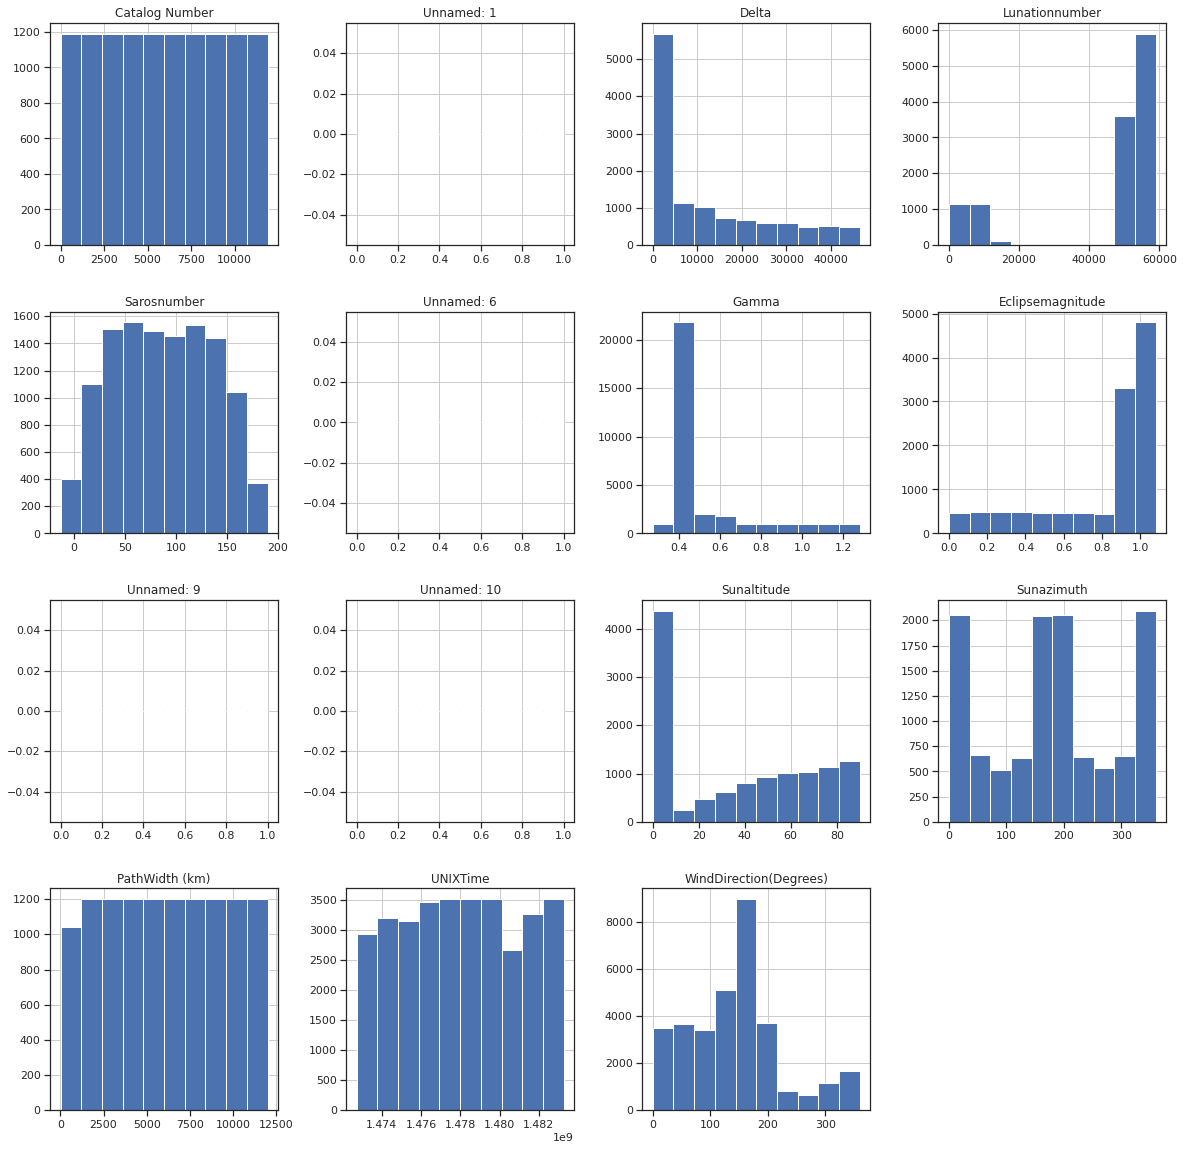

In [ ]:
data.hist(figsize=(20,20))
plt.show()

In [ ]:
def diagnostic_plots(df, variable):
    plt.figure(figsize=(15,6))
    # гистограмма
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()

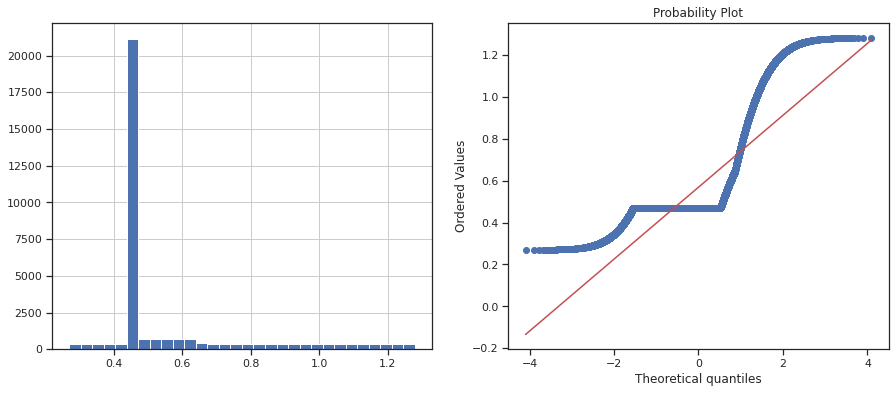

In [ ]:
diagnostic_plots(data, 'Gamma')

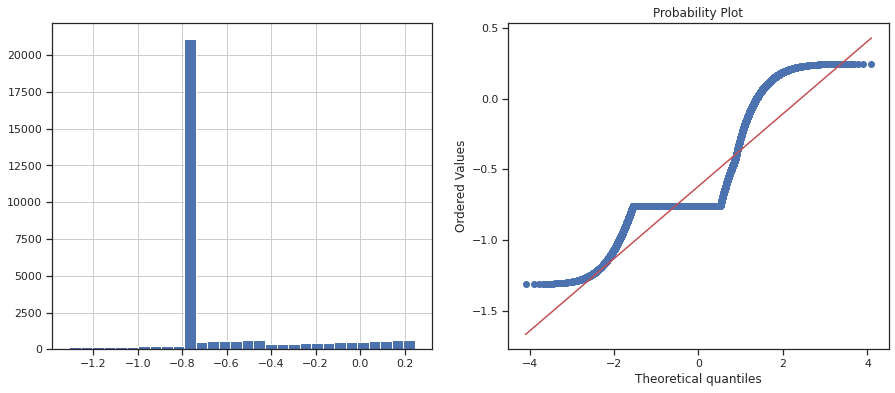

In [ ]:
data['Gamma_log'] = np.log(data['Gamma'])
diagnostic_plots(data, 'Gamma_log')

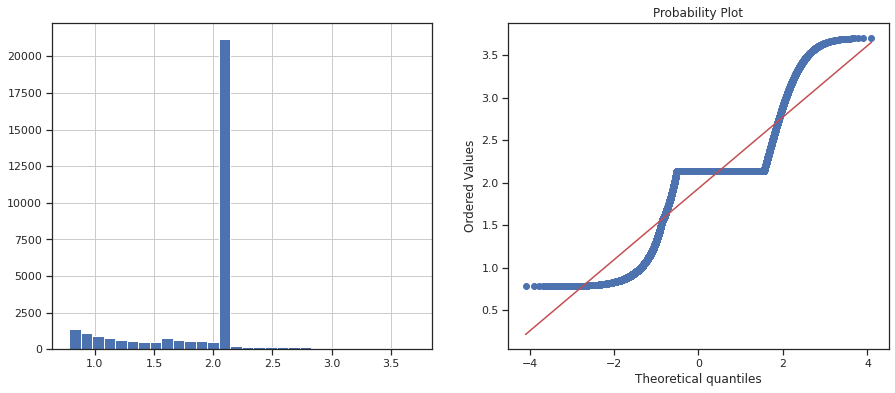

In [ ]:
data['Gamma_reciprocal'] = 1 / (data['Gamma']) 
diagnostic_plots(data, 'Gamma_reciprocal')

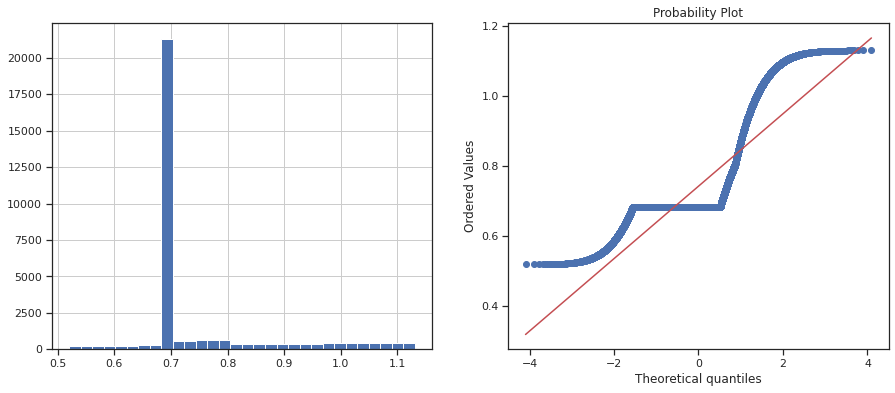

In [ ]:
data['Gamma_sqr'] = data['Gamma']**(1/2) 
diagnostic_plots(data, 'Gamma_sqr')

Оптимальное значение λ = -1.597211394590668


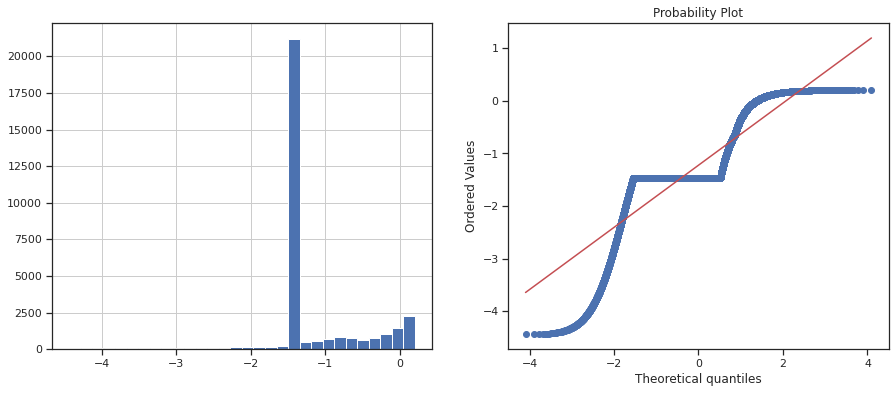

In [ ]:
data['Gamma_boxcox'], param = stats.boxcox(data['Gamma']) 
print('Оптимальное значение λ = {}'.format(param))
diagnostic_plots(data, 'Gamma_boxcox')

Оптимальное значение λ = -6.335929584796748


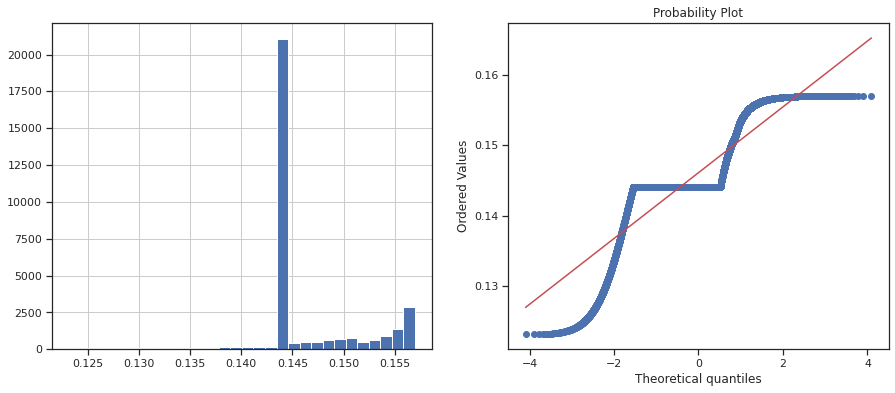

In [ ]:
# Необходимо преобразовать данные к действительному типу
data['Gamma'] = data['Gamma'].astype('float')
data['Gamma_yeojohnson'], param = stats.yeojohnson(data['Gamma']) 
print('Оптимальное значение λ = {}'.format(param))
diagnostic_plots(data, 'Gamma_yeojohnson')

# **Масштабирование признаков**

**На основе Z-оценки**

In [ ]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler

In [ ]:
cols_to_scale = [ 'Delta', 'Lunationnumber', 'Sarosnumber', 'Gamma', 'Sunazimuth', 'UNIXTime']

data_to_scale = data_loaded[cols_to_scale]
data_to_scale = data_to_scale.dropna()
data_to_scale.describe()

,Delta,Lunationnumber,Sarosnumber,Gamma,Sunazimuth,UNIXTime
count,11898.000000,11898.000000,11898.000000,11898.000000,11898.000000,1.189800e+04
mean,12142.172802,44567.074971,87.483190,0.742000,180.264330,1.475260e+09
std,13583.402888,19443.399140,48.380284,0.280094,110.745408,1.721177e+06
min,-6.000000,1.000000,-13.000000,0.270100,0.000000,1.472724e+09
25%,970.250000,50038.250000,47.000000,0.518025,89.000000,1.473790e+09
50%,5636.500000,53012.500000,87.000000,0.684550,180.000000,1.474776e+09
75%,20943.500000,55986.750000,128.000000,0.981975,272.000000,1.477099e+09
max,46438.000000,58961.000000,190.000000,1.279400,360.000000,1.477994e+09


In [ ]:
X_ALL = data_to_scale.drop('Sarosnumber', axis=1)
X_ALL

,Delta,Lunationnumber,Gamma,Sunazimuth,UNIXTime
0,46438.0,49456.0,0.2701,344.0,1475229326
1,46426.0,49457.0,0.2702,21.0,1475229023
2,46415.0,49458.0,0.2703,151.0,1475228726
3,46403.0,49459.0,0.2704,74.0,1475228421
4,46393.0,49460.0,0.2705,281.0,1475228124
...,...,...,...,...,...
11893,4414.0,12355.0,0.6485,179.0,1476646820
11894,4417.0,12360.0,0.6486,146.0,1476646521
11895,4420.0,12366.0,0.6487,137.0,1476646222
11896,4424.0,12372.0,0.6488,166.0,1476645923


In [ ]:
# Функция восстановления датафрейма на основе масштабированных данных 
def arr_to_df(arr_scaled):
    res = pd.DataFrame(arr_scaled, columns=X_ALL.columns)
    return res

In [ ]:
# Разделим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X_ALL, data_to_scale['Delta'],
                                                    test_size=0.2,
                                                    random_state=1)
# Преобразуем массивы в DataFrame
X_train_df = arr_to_df(X_train)
X_test_df = arr_to_df(X_test)

X_train_df.shape, X_test_df.shape

((9518, 5), (2380, 5))

In [ ]:
# Обучаем StandardScaler на всей выборке и масштабируем
cs11 = StandardScaler()
data_cs11_scaled_temp = cs11.fit_transform(X_ALL)
# формируем DataFrame на основе массива
data_cs11_scaled =  arr_to_df(data_cs11_scaled_temp)
data_cs11_scaled

,Delta,Lunationnumber,Gamma,Sunazimuth,UNIXTime
0,2.524939,0.251455,-1.684859,1.478549,-0.017953
1,2.524056,0.251506,-1.684502,-1.438173,-0.018129
2,2.523246,0.251557,-1.684145,-0.264260,-0.018301
3,2.522363,0.251609,-1.683788,-0.959577,-0.018478
4,2.521626,0.251660,-1.683431,0.909653,-0.018651
...,...,...,...,...,...
11893,-0.568966,-1.656780,-0.333829,-0.011417,0.805643
11894,-0.568745,-1.656523,-0.333472,-0.309410,0.805469
11895,-0.568525,-1.656214,-0.333115,-0.390681,0.805295
11896,-0.568230,-1.655905,-0.332758,-0.128808,0.805122


In [ ]:
def draw_kde(col_list, df1, df2, label1, label2):
    fig, (ax1, ax2) = plt.subplots(
        ncols=2, figsize=(12, 5))
    # первый график
    ax1.set_title(label1)
    sns.kdeplot(data=df1[col_list], ax=ax1)
    # второй график
    ax2.set_title(label2)
    sns.kdeplot(data=df2[col_list], ax=ax2)
    plt.show()

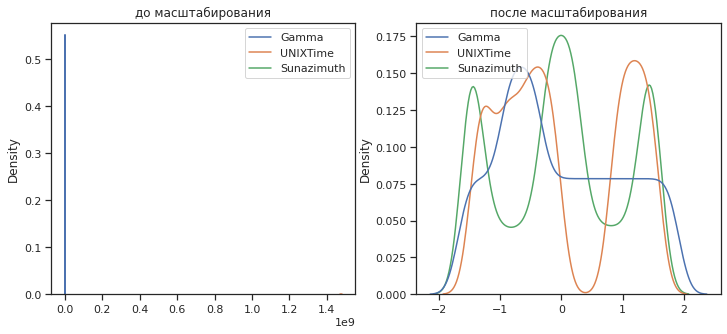

In [ ]:
draw_kde(['Gamma', 'UNIXTime', 'Sunazimuth'], data_to_scale, data_cs11_scaled, 'до масштабирования', 'после масштабирования')

In [ ]:
# Обучаем StandardScaler на обучающей выборке 
# и масштабируем обучающую и тестовую выборки
cs12 = StandardScaler()
cs12.fit(X_train)
data_cs12_scaled_train_temp = cs12.transform(X_train)
data_cs12_scaled_test_temp = cs12.transform(X_test)
# формируем DataFrame на основе массива
data_cs12_scaled_train = arr_to_df(data_cs12_scaled_train_temp)
data_cs12_scaled_test = arr_to_df(data_cs12_scaled_test_temp)

In [ ]:
data_cs12_scaled_train.describe()

,Delta,Lunationnumber,Gamma,Sunazimuth,UNIXTime
count,9.518000e+03,9.518000e+03,9.518000e+03,9.518000e+03,9.518000e+03
mean,6.270812e-17,1.524370e-16,2.076273e-18,-5.431554e-17,-1.940655e-15
std,1.000053e+00,1.000053e+00,1.000053e+00,1.000053e+00,1.000053e+00
min,-8.910189e-01,-2.283891e+00,-1.692118e+00,-1.630871e+00,-1.470371e+00
25%,-8.192373e-01,2.833294e-01,-8.001160e-01,-8.172697e-01,-8.565046e-01
50%,-4.855315e-01,4.361728e-01,-2.038979e-01,5.371963e-03,-2.820099e-01
75%,6.424649e-01,5.894395e-01,8.575454e-01,8.280137e-01,1.066264e+00
max,2.541490e+00,7.411670e-01,1.917737e+00,1.623535e+00,1.583937e+00


In [ ]:
data_cs12_scaled_test.describe()

,Delta,Lunationnumber,Gamma,Sunazimuth,UNIXTime
count,2380.000000,2380.000000,2380.000000,2380.000000,2380.000000
mean,0.034038,0.013290,-0.021623,-0.006391,-0.002078
std,1.018901,0.987776,1.008701,1.005675,0.987785
min,-0.891019,-2.283327,-1.690688,-1.630871,-1.470195
25%,-0.817223,0.283432,-0.827030,-0.853430,-0.836857
50%,-0.419792,0.433684,-0.229471,-0.012708,-0.278011
75%,0.697433,0.585771,0.838411,0.837054,1.060439
max,2.538164,0.740911,1.916306,1.623535,1.584109


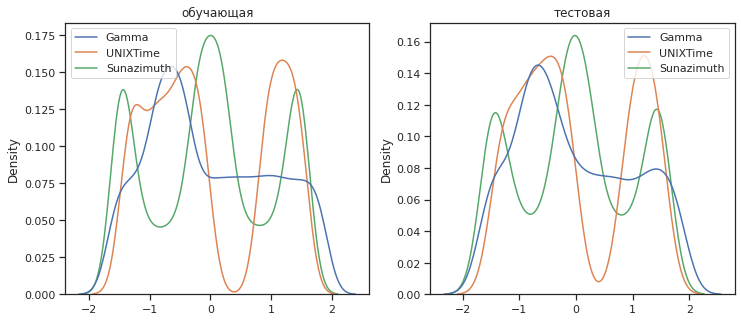

In [ ]:
# распределения для обучающей и тестовой выборки немного отличаются
draw_kde(['Gamma', 'UNIXTime', 'Sunazimuth'], data_cs12_scaled_train, data_cs12_scaled_test, 'обучающая', 'тестовая')

**Масштабирование "Mean Normalisation"**

In [ ]:
class MeanNormalisation:
    
    def fit(self, param_df):
        self.means = X_train.mean(axis=0)
        maxs = X_train.max(axis=0)
        mins = X_train.min(axis=0)
        self.ranges = maxs - mins

    def transform(self, param_df):
        param_df_scaled = (param_df - self.means) / self.ranges
        return param_df_scaled
    
    def fit_transform(self, param_df):
        self.fit(param_df)
        return self.transform(param_df)

In [ ]:
sc21 = MeanNormalisation()
data_cs21_scaled = sc21.fit_transform(X_ALL)
data_cs21_scaled.describe()

,Delta,Lunationnumber,Gamma,Sunazimuth,UNIXTime
count,11898.000000,11898.000000,11898.000000,11898.000000,11898.000000
mean,0.001984,0.000879,-0.001198,-0.000393,-0.000136
std,0.292468,0.329773,0.277513,0.307626,0.326611
min,-0.259582,-0.754991,-0.468750,-0.501127,-0.481409
25%,-0.238562,0.093674,-0.223109,-0.253905,-0.279130
50%,-0.138092,0.144119,-0.058118,-0.001127,-0.092104
75%,0.191488,0.194564,0.236566,0.254428,0.348818
max,0.740418,0.245009,0.531250,0.498873,0.518648


In [ ]:
cs22 = MeanNormalisation()
cs22.fit(X_train)
data_cs22_scaled_train = cs22.transform(X_train)
data_cs22_scaled_test = cs22.transform(X_test)

In [ ]:
data_cs22_scaled_train.describe()

,Delta,Lunationnumber,Gamma,Sunazimuth,UNIXTime
count,9.518000e+03,9.518000e+03,9.518000e+03,9.518000e+03,9.518000e+03
mean,1.947964e-17,4.507729e-17,2.165915e-16,-2.150634e-18,-6.369071e-16
std,2.913474e-01,3.305895e-01,2.770340e-01,3.072918e-01,3.274236e-01
min,-2.595824e-01,-7.549908e-01,-4.687496e-01,-5.011271e-01,-4.814087e-01
25%,-2.386701e-01,9.366079e-02,-2.216477e-01,-2.511271e-01,-2.804251e-01
50%,-1.414509e-01,1.441866e-01,-5.648368e-02,1.650674e-03,-9.233187e-02
75%,1.871707e-01,1.948523e-01,2.375567e-01,2.544285e-01,3.491017e-01
max,7.404176e-01,2.450092e-01,5.312504e-01,4.988729e-01,5.185913e-01


In [ ]:
data_cs22_scaled_test.describe()

,Delta,Lunationnumber,Gamma,Sunazimuth,UNIXTime
count,2380.000000,2380.000000,2380.000000,2380.000000,2380.000000
mean,0.009916,0.004393,-0.005990,-0.001964,-0.000680
std,0.296839,0.326531,0.279430,0.309019,0.323407
min,-0.259582,-0.754804,-0.468353,-0.501127,-0.481351
25%,-0.238083,0.093695,-0.229103,-0.262238,-0.273992
50%,-0.122299,0.143364,-0.063568,-0.003905,-0.091022
75%,0.203185,0.193640,0.232256,0.257206,0.347195
max,0.739449,0.244924,0.530854,0.498873,0.518648


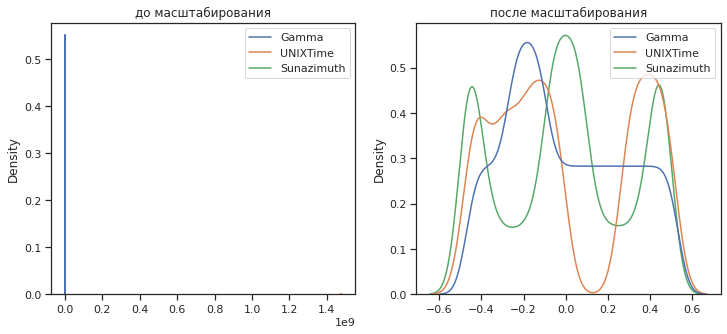

In [ ]:
draw_kde(['Gamma', 'UNIXTime', 'Sunazimuth'], data_to_scale, data_cs21_scaled, 'до масштабирования', 'после масштабирования')

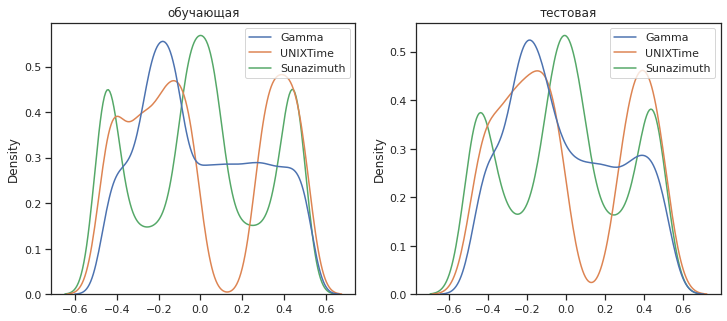

In [ ]:
draw_kde(['Gamma', 'UNIXTime', 'Sunazimuth'], data_cs22_scaled_train, data_cs22_scaled_test, 'обучающая', 'тестовая')

**Min-Max Масштабирование**

In [ ]:
# Обучаем StandardScaler на всей выборке и масштабируем
cs31 = MinMaxScaler()
data_cs31_scaled_temp = cs31.fit_transform(X_ALL)
# формируем DataFrame на основе массива
data_cs31_scaled = arr_to_df(data_cs31_scaled_temp)
data_cs31_scaled.describe()

,Delta,Lunationnumber,Gamma,Sunazimuth,UNIXTime
count,11898.000000,11898.000000,11898.000000,11898.000000,11898.000000
mean,0.261566,0.755870,0.467551,0.500734,0.481246
std,0.292468,0.329773,0.277513,0.307626,0.326592
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.021020,0.848664,0.245641,0.247222,0.202267
50%,0.121490,0.899110,0.410631,0.500000,0.389283
75%,0.451070,0.949555,0.705316,0.755556,0.830180
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
cs32 = MinMaxScaler()
cs32.fit(X_train)
data_cs32_scaled_train_temp = cs32.transform(X_train)
data_cs32_scaled_test_temp = cs32.transform(X_test)
# формируем DataFrame на основе массива
data_cs32_scaled_train = arr_to_df(data_cs32_scaled_train_temp)
data_cs32_scaled_test = arr_to_df(data_cs32_scaled_test_temp)

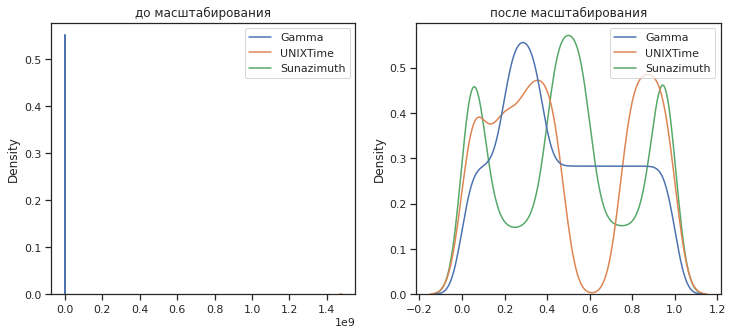

In [ ]:
draw_kde(['Gamma', 'UNIXTime', 'Sunazimuth'], data_to_scale, data_cs31_scaled, 'до масштабирования', 'после масштабирования')

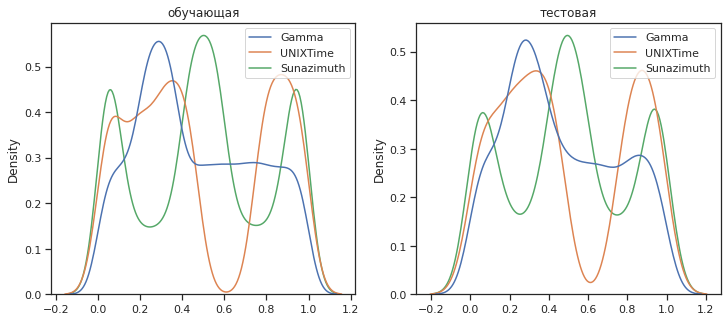

In [ ]:
draw_kde(['Gamma', 'UNIXTime', 'Sunazimuth'], data_cs32_scaled_train, data_cs32_scaled_test, 'обучающая', 'тестовая')

**Масштабирование по медиане**

In [ ]:
cs41 = RobustScaler()
data_cs41_scaled_temp = cs41.fit_transform(X_ALL)
# формируем DataFrame на основе массива
data_cs41_scaled = arr_to_df(data_cs41_scaled_temp)
data_cs41_scaled.describe()

,Delta,Lunationnumber,Gamma,Sunazimuth,UNIXTime
count,11898.000000,11898.000000,11898.000000,11898.000000,11898.000000
mean,0.325719,-1.419757,0.123827,0.001444,0.146457
std,0.680080,3.268622,0.603717,0.605166,0.520124
min,-0.282503,-8.911742,-0.893307,-0.983607,-0.619964
25%,-0.233625,-0.500000,-0.358929,-0.497268,-0.297838
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.766375,0.500000,0.641071,0.502732,0.702162
max,2.042807,1.000000,1.282142,0.983607,0.972615


In [ ]:
cs42 = RobustScaler()
cs42.fit(X_train)
data_cs42_scaled_train_temp = cs42.transform(X_train)
data_cs42_scaled_test_temp = cs42.transform(X_test)
# формируем DataFrame на основе массива
data_cs42_scaled_train = arr_to_df(data_cs42_scaled_train_temp)
data_cs42_scaled_test = arr_to_df(data_cs42_scaled_test_temp)

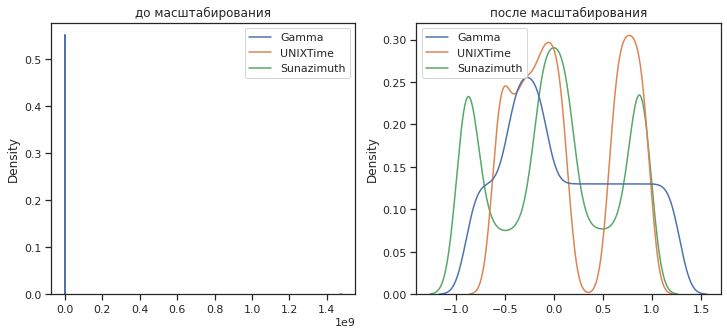

In [ ]:
draw_kde(['Gamma', 'UNIXTime', 'Sunazimuth'], data_to_scale, data_cs41_scaled, 'до масштабирования', 'после масштабирования')

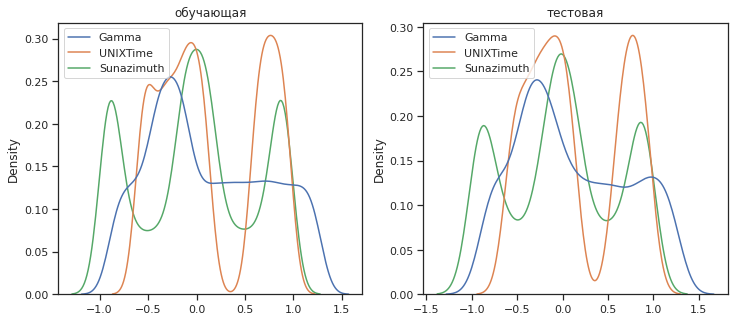

In [ ]:
draw_kde(['Gamma', 'UNIXTime', 'Sunazimuth'], data_cs42_scaled_train, data_cs42_scaled_test, 'обучающая', 'тестовая')

**Масштабирование по максимальному значению**

In [ ]:
cs51 = MaxAbsScaler()
data_cs51_scaled_temp = cs51.fit_transform(X_ALL)
# формируем DataFrame на основе массива
data_cs51_scaled = arr_to_df(data_cs51_scaled_temp)
data_cs51_scaled.describe()

,Delta,Lunationnumber,Gamma,Sunazimuth,UNIXTime
count,11898.000000,11898.000000,11898.000000,11898.000000,11898.000000
mean,0.261471,0.755874,0.579959,0.500734,0.998150
std,0.292506,0.329767,0.218926,0.307626,0.001165
min,-0.000129,0.000017,0.211115,0.000000,0.996434
25%,0.020893,0.848667,0.404897,0.247222,0.997156
50%,0.121377,0.899111,0.535055,0.500000,0.997822
75%,0.450999,0.949556,0.767528,0.755556,0.999394
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
cs52_mas = MaxAbsScaler()
cs52_mean = StandardScaler(with_mean=True, with_std=False)

cs52_mas.fit(X_train)
cs52_mean.fit(X_train)

data_cs52_scaled_train_temp = cs52_mas.transform(cs52_mean.transform(X_train))
data_cs52_scaled_test_temp = cs52_mas.transform(cs52_mean.transform(X_test))
# формируем DataFrame на основе массива
data_cs52_scaled_train = arr_to_df(data_cs52_scaled_train_temp)
data_cs52_scaled_test = arr_to_df(data_cs52_scaled_test_temp)

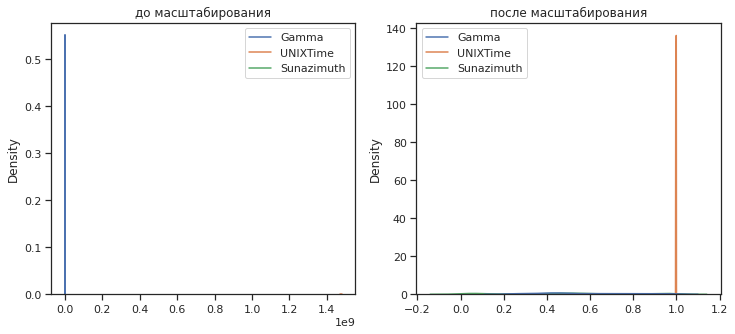

In [ ]:
draw_kde(['Gamma', 'UNIXTime', 'Sunazimuth'], data_to_scale, data_cs51_scaled, 'до масштабирования', 'после масштабирования')

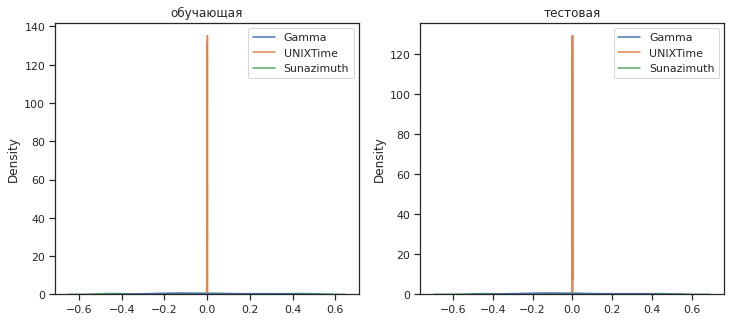

In [ ]:
draw_kde(['Gamma', 'UNIXTime', 'Sunazimuth'], data_cs52_scaled_train, data_cs52_scaled_test, 'обучающая', 'тестовая')

# **Обучение моделей с различными вариантами масштабирования признаков**

In [ ]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='white')
        plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [ ]:
clas_models_dict = {'LinR': LinearRegression(), 
                    'SVR': SVR(),
                    'KNN_5':KNeighborsRegressor(n_neighbors=5),
                    'Tree':DecisionTreeRegressor(random_state=1),
                    'GB': GradientBoostingRegressor(random_state=1),
                    'RF':RandomForestRegressor(n_estimators=50, random_state=1)}

In [ ]:
X_data_dict = {'Original': (X_train_df, X_test_df),
               'StandardScaler': (data_cs12_scaled_train, data_cs12_scaled_test), 
               'MeanNormalisation': (data_cs22_scaled_train, data_cs22_scaled_test),
               'MinMaxScaler': (data_cs32_scaled_train, data_cs32_scaled_test), 
               'RobustScaler': (data_cs42_scaled_train, data_cs42_scaled_test),
               'MaxAbsScaler': (data_cs52_scaled_train, data_cs52_scaled_test)}

In [ ]:
def test_models(clas_models_dict, X_data_dict, y_train, y_test):
    
    logger = MetricLogger()
    
    for model_name, model in clas_models_dict.items():
        
        for data_name, data_tuple in X_data_dict.items():

            X_train, X_test = data_tuple
              
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            logger.add(model_name, data_name, mse)
            
    return logger

In [ ]:
%%time
logger = test_models(clas_models_dict, X_data_dict, y_train, y_test)

CPU times: user 1min 5s, sys: 376 ms, total: 1min 6s
Wall time: 1min 5s


ValueError: ignored

<Figure size 504x432 with 1 Axes>

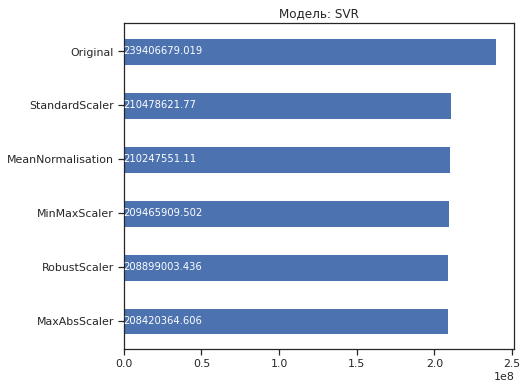

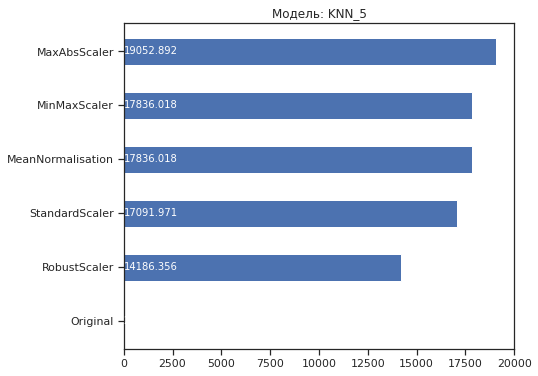

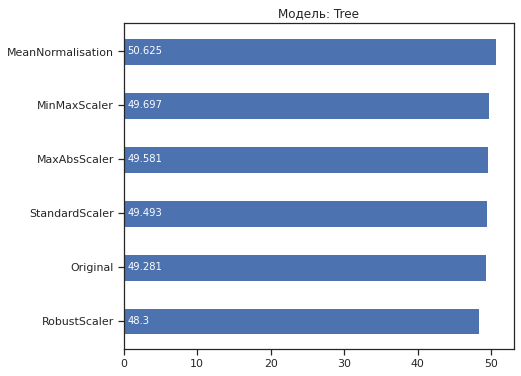

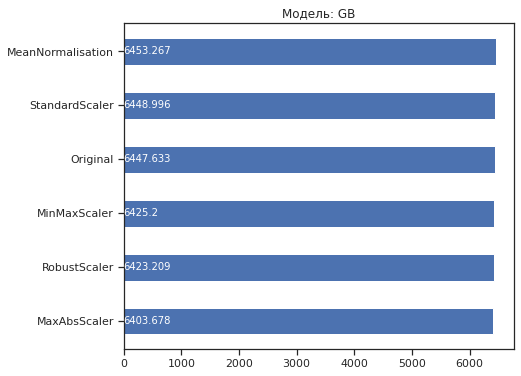

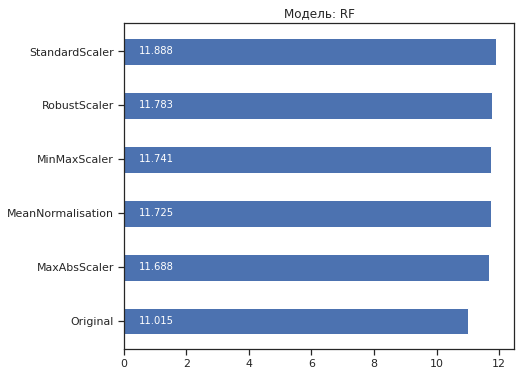

In [ ]:
# Построим графики метрик качества модели
for model in clas_models_dict:
    logger.plot('Модель: ' + model, model, figsize=(7, 6))

# **Обработка выбросов**

In [ ]:
x_col_list = ['UNIXTime', 'Sunazimuth', 'Gamma']

In [ ]:
data_to_scale.shape

(11898, 6)

In [ ]:
def diagnostic_plots(df, variable, title):
    fig, ax = plt.subplots(figsize=(10,7))
    # гистограмма
    plt.subplot(2, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(2, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    # ящик с усами
    plt.subplot(2, 2, 3)
    sns.violinplot(x=df[variable])    
    # ящик с усами
    plt.subplot(2, 2, 4)
    sns.boxplot(x=df[variable])  
    fig.suptitle(title)
    plt.show()

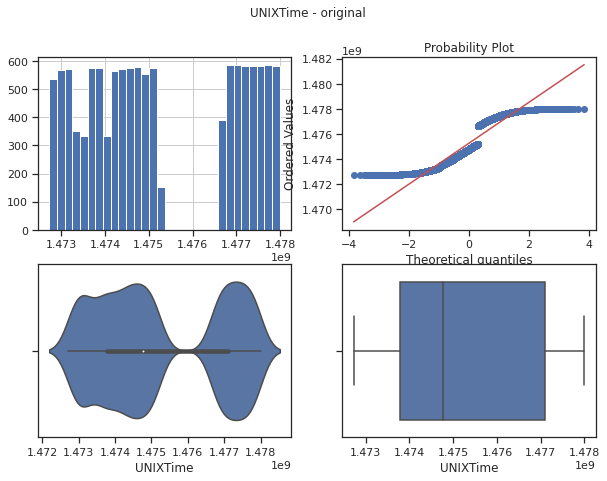

In [ ]:
diagnostic_plots(data_to_scale, 'UNIXTime', 'UNIXTime - original')

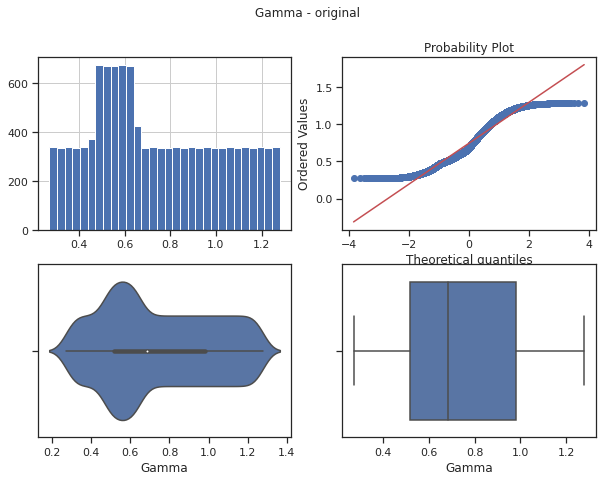

In [ ]:
diagnostic_plots(data_to_scale, 'Gamma', 'Gamma - original')

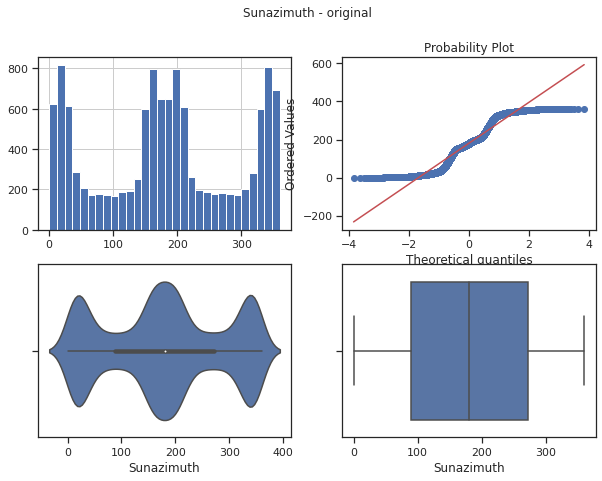

In [ ]:
diagnostic_plots(data_to_scale, 'Sunazimuth', 'Sunazimuth - original')

**Обнаружение выбросов**

In [ ]:
# Тип вычисления верхней и нижней границы выбросов
from enum import Enum
class OutlierBoundaryType(Enum):
    SIGMA = 1
    QUANTILE = 2
    IRQ = 3

In [ ]:
# Функция вычисления верхней и нижней границы выбросов
def get_outlier_boundaries(df, col, outlier_boundary_type: OutlierBoundaryType):
    if outlier_boundary_type == OutlierBoundaryType.SIGMA:
        K1 = 3
        lower_boundary = df[col].mean() - (K1 * df[col].std())
        upper_boundary = df[col].mean() + (K1 * df[col].std())

    elif outlier_boundary_type == OutlierBoundaryType.QUANTILE:
        lower_boundary = df[col].quantile(0.05)
        upper_boundary = df[col].quantile(0.95)

    elif outlier_boundary_type == OutlierBoundaryType.IRQ:
        K2 = 1.5
        IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
        lower_boundary = df[col].quantile(0.25) - (K2 * IQR)
        upper_boundary = df[col].quantile(0.75) + (K2 * IQR)

    else:
        raise NameError('Unknown Outlier Boundary Type')
        
    return lower_boundary, upper_boundary

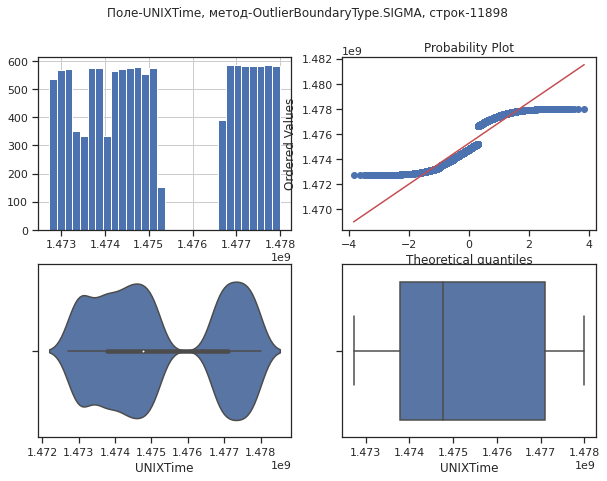

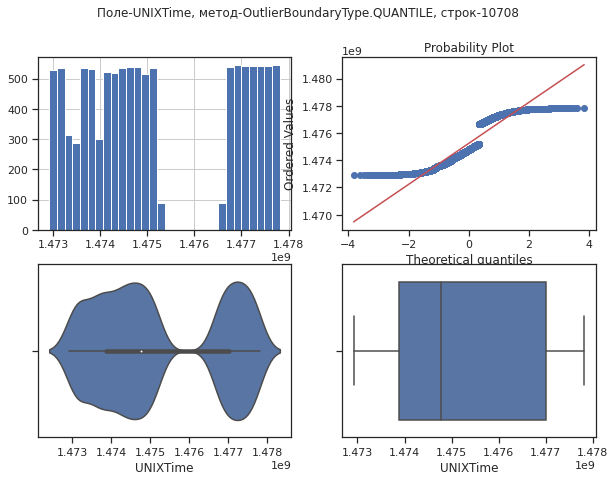

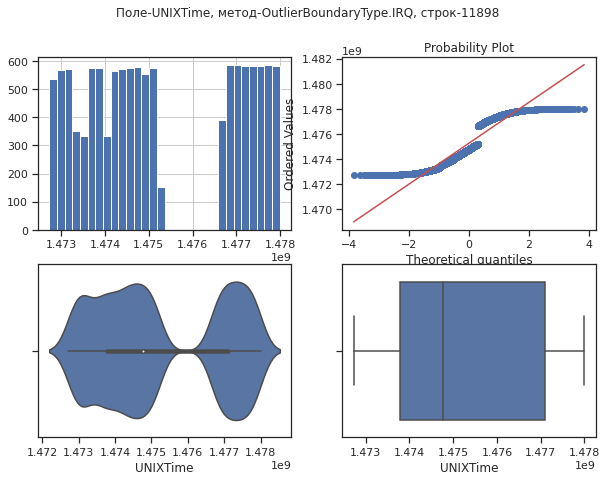

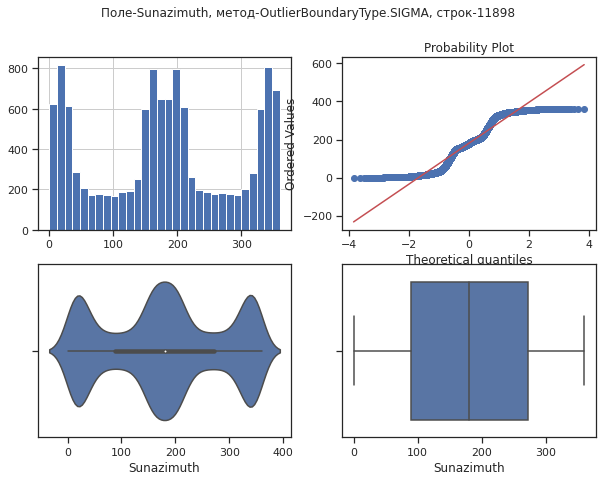

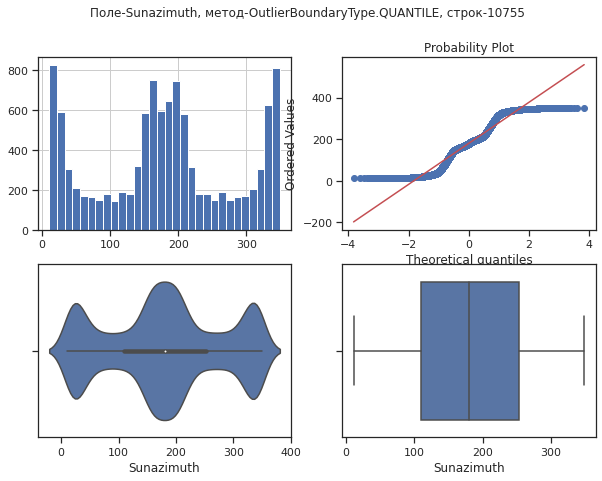

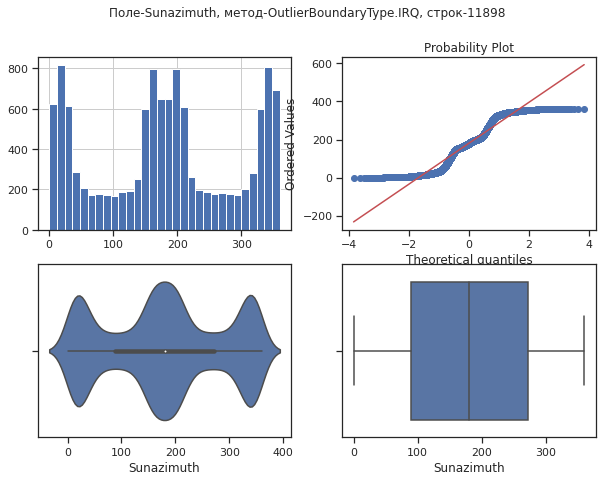

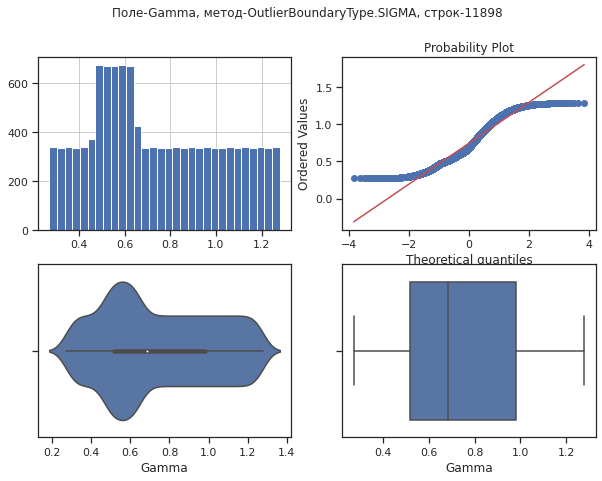

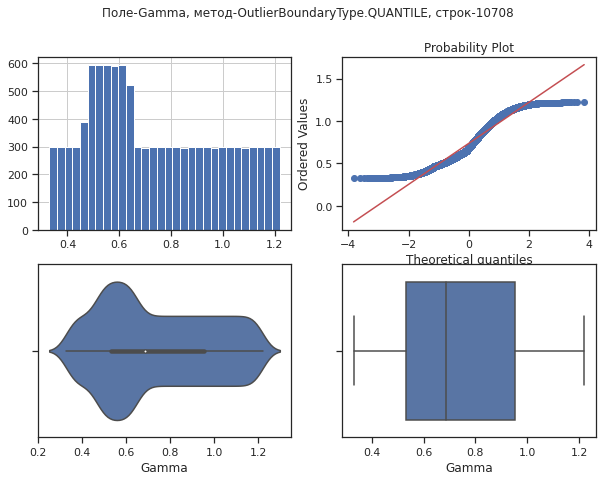

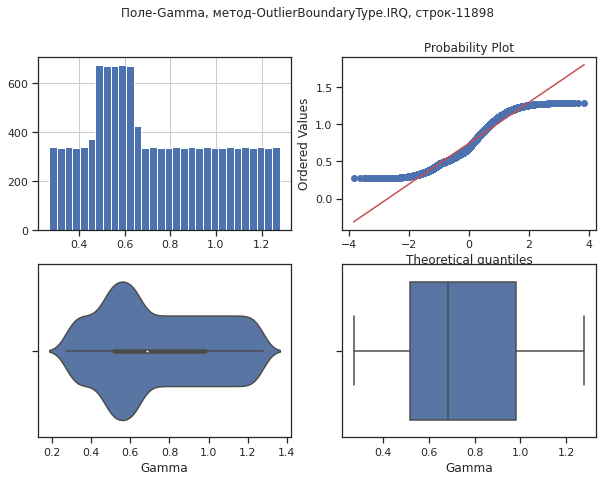

In [ ]:
for col in x_col_list:    
    for obt in OutlierBoundaryType:
        # Вычисление верхней и нижней границы
        lower_boundary, upper_boundary = get_outlier_boundaries(data_to_scale, col, obt)
        # Флаги для удаления выбросов
        outliers_temp = np.where(data_to_scale[col] > upper_boundary, True, 
                                 np.where(data_to_scale[col] < lower_boundary, True, False))
        # Удаление данных на основе флага
        data_trimmed = data_to_scale.loc[~(outliers_temp), ]  
        title = 'Поле-{}, метод-{}, строк-{}'.format(col, obt, data_trimmed.shape[0])
        diagnostic_plots(data_trimmed, col, title)

**Замена выбросов**

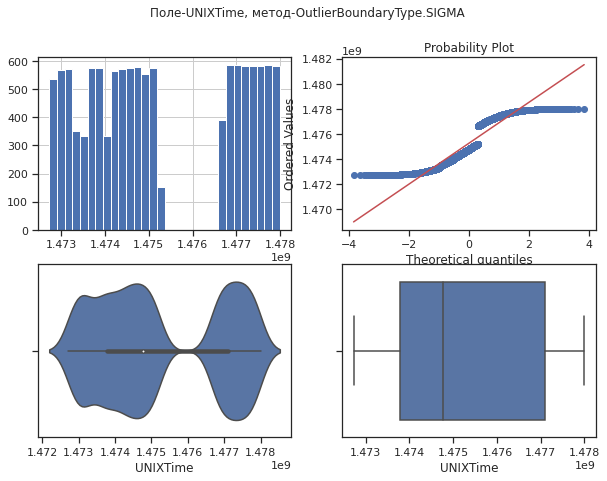

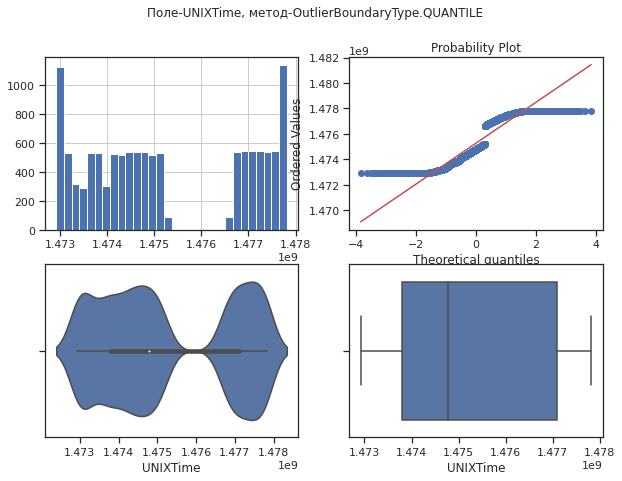

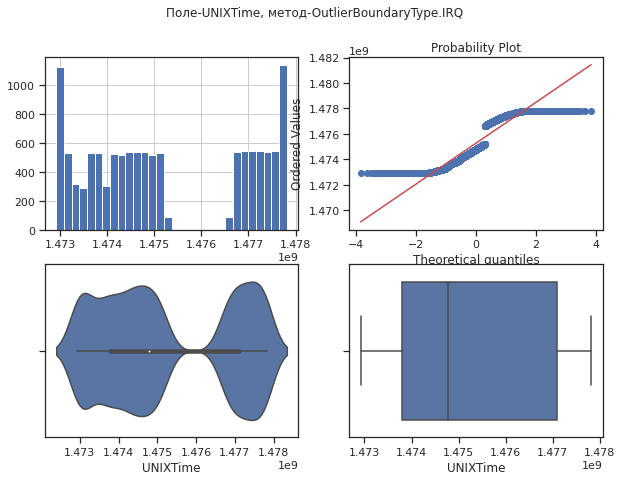

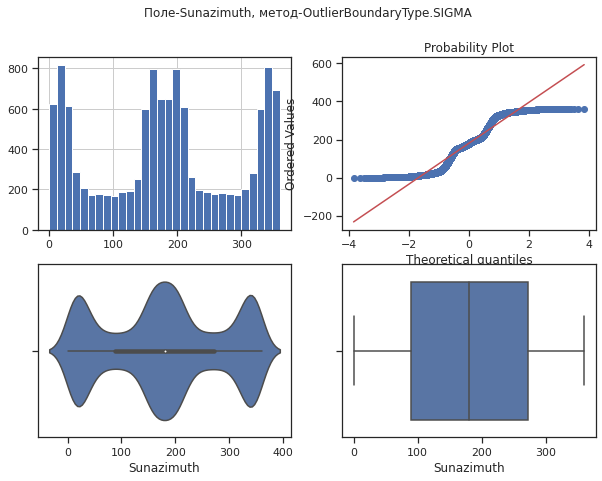

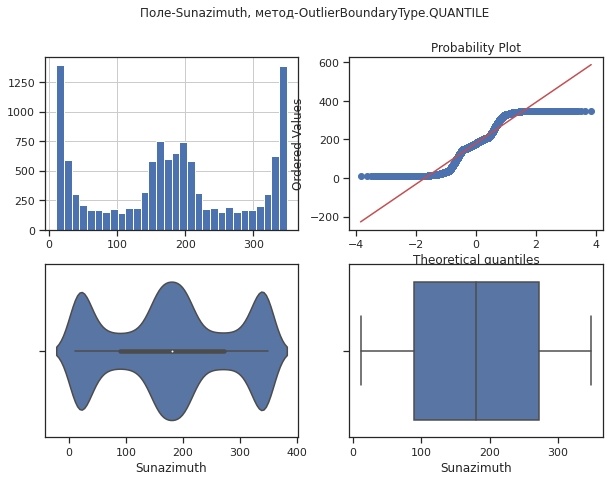

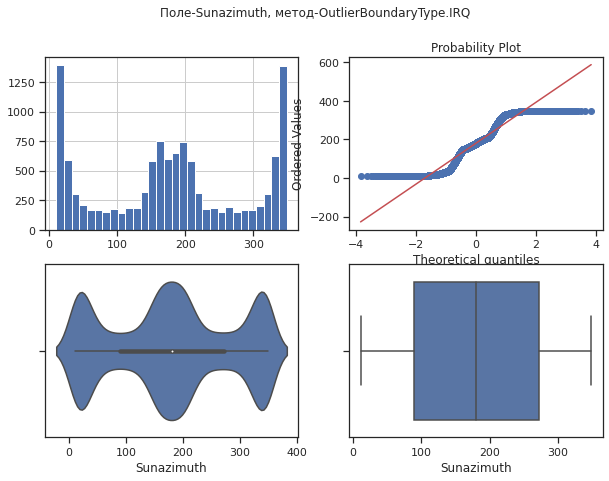

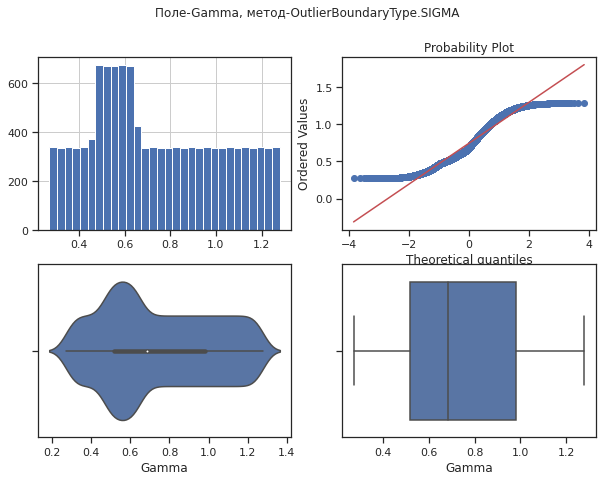

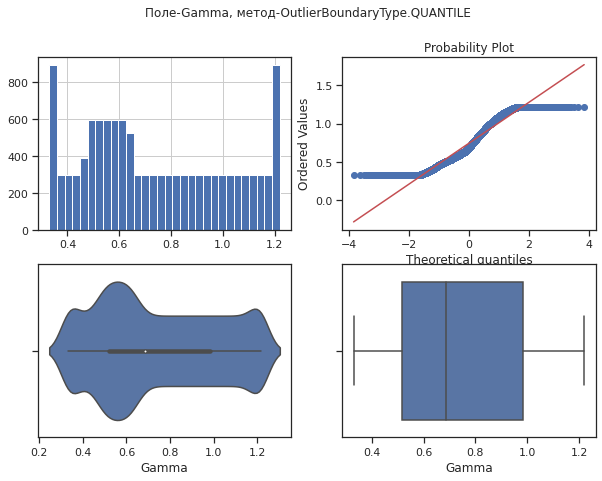

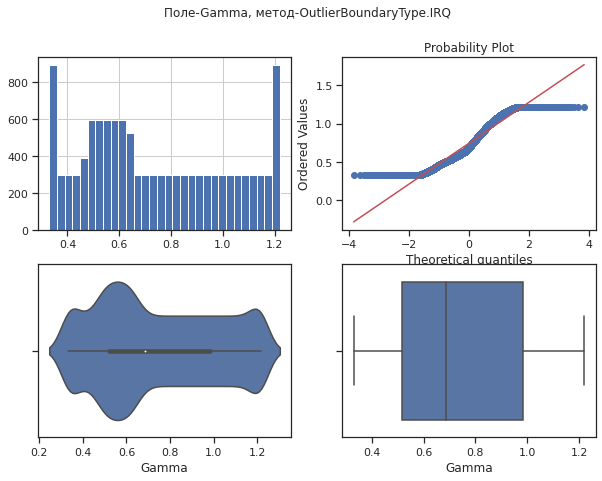

In [ ]:
for col in x_col_list:    
    for obt in OutlierBoundaryType:
        # Вычисление верхней и нижней границы
        lower_boundary, upper_boundary = get_outlier_boundaries(data_to_scale, col, obt)
        # Изменение данных
        data_to_scale[col] = np.where(data_to_scale[col] > upper_boundary, upper_boundary, 
                                 np.where(data_to_scale[col] < lower_boundary, lower_boundary, data_to_scale[col]))
        title = 'Поле-{}, метод-{}'.format(col, obt)
        diagnostic_plots(data_to_scale, col, title)

Типы признаков:
1.   Бинарный - Gender
2.   Вещественный
3.   Категориальный
4.   Порядковый
5.   Set-valued --> (Heard about school form?) - признак являющийся подмножеством какого-либо множества (например, список просмотренных пользователем фильмов - подмножество всех фильмов). В данном случае - признак 'Откуда узнал о Школе21' - подмножество всех возможных способов рекламы

# **Отбор признаков**
# **Метод фильтрации**
**Метод, основынный на корреляции**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.datasets import load_boston
import scipy.stats as stats
from sklearn.svm import SVR
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile
from IPython.display import Image
%matplotlib inline 
sns.set(style="ticks")

In [ ]:
cols_to_fs = ['Catalog Number','Delta','Lunationnumber','Sarosnumber', 
              'Gamma','Eclipsemagnitude','Sunaltitude','Sunazimuth',  'PathWidth (km)', 
              'UNIXTime', 'WindDirection(Degrees)']
fs_data = data_loaded[cols_to_fs].copy()
fs_data.shape

(32686, 11)

In [ ]:
fs_data_features = list(zip(
[i for i in fs_data.columns],
zip(
    #типы колонок
    [str(i) for i in fs_data.dtypes],
    #проверка, есть ли пропущенные значения
    [i for i in fs_data.isnull().sum()]
)))
fs_data_features

[('Catalog Number', ('float64', 20788)),
 ('Delta', ('float64', 20788)),
 ('Lunationnumber', ('float64', 20788)),
 ('Sarosnumber', ('float64', 20788)),
 ('Gamma', ('float64', 20788)),
 ('Eclipsemagnitude', ('float64', 20788)),
 ('Sunaltitude', ('float64', 20788)),
 ('Sunazimuth', ('float64', 20788)),
 ('PathWidth (km)', ('float64', 20835)),
 ('UNIXTime', ('int64', 0)),
 ('WindDirection(Degrees)', ('float64', 0))]

In [ ]:
fs_data.tail()

,Catalog Number,Delta,Lunationnumber,Sarosnumber,Gamma,Eclipsemagnitude,Sunaltitude,Sunazimuth,PathWidth (km),UNIXTime,WindDirection(Degrees)
32681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1480587604,145.42
32682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1480587301,117.78
32683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1480587001,145.19
32684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1480586702,164.19
32685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1480586402,83.59


In [ ]:
fs_data = fs_data.dropna()
fs_data.shape

(11851, 11)

In [ ]:
g_cat_enc_le = le.fit_transform(fs_data['UNIXTime'])
g_cat_enc_le

array([7416, 7415, 7414, ..., 7419, 7418, 7417])

In [ ]:
fs_data['Gender'] = g_cat_enc_le
fs_data['Gender']

0        7416
1        7415
2        7414
3        7413
4        7412
         ... 
11890    7421
11891    7420
11894    7419
11896    7418
11897    7417
Name: Gender, Length: 11851, dtype: int64

In [ ]:
fs_data

,Catalog Number,Delta,Lunationnumber,Sarosnumber,Gamma,Eclipsemagnitude,Sunaltitude,Sunazimuth,PathWidth (km),UNIXTime,WindDirection(Degrees),Gender
0,1.0,46438.0,49456.0,5.0,0.2701,1.0733,74.0,344.0,247.0,1475229326,177.39,7416
1,2.0,46426.0,49457.0,10.0,0.2702,0.9382,76.0,21.0,248.0,1475229023,176.78,7415
2,3.0,46415.0,49458.0,15.0,0.2703,1.0284,60.0,151.0,249.0,1475228726,158.75,7414
3,4.0,46403.0,49459.0,20.0,0.2704,0.9806,25.0,74.0,250.0,1475228421,137.71,7413
4,5.0,46393.0,49460.0,-13.0,0.2705,0.1611,0.0,281.0,251.0,1475228124,104.95,7412
...,...,...,...,...,...,...,...,...,...,...,...,...
11890,11891.0,4403.0,12337.0,172.0,0.6482,0.9916,74.0,8.0,31.0,1476647720,139.92,7421
11891,11892.0,4406.0,12343.0,177.0,0.6483,0.9696,57.0,175.0,130.0,1476647419,90.57,7420
11894,11895.0,4417.0,12360.0,154.0,0.6486,1.0566,33.0,146.0,345.0,1476646521,131.57,7419
11896,11897.0,4424.0,12372.0,164.0,0.6488,1.0222,82.0,166.0,76.0,1476645923,154.12,7418


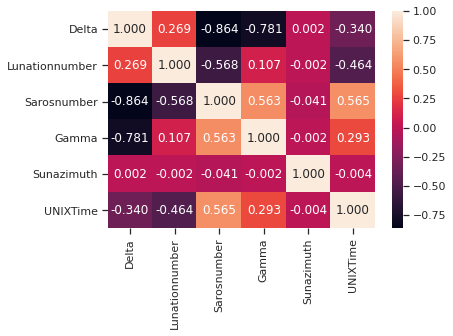

In [ ]:
heatmap_cols = [ 'Delta', 'Lunationnumber', 'Sarosnumber', 'Gamma', 'Sunazimuth', 'UNIXTime']
sns.heatmap(fs_data[heatmap_cols].corr(), annot=True, fmt='.3f')

In [ ]:
# Формирование DataFrame с сильными корреляциями
def make_corr_df(df):
    cr = df.corr() # !!!вот здесь был недочет - data.corr -> df.corr
    cr = cr.abs().unstack() 
    cr = cr.sort_values(ascending=False)
    cr = cr[cr >= 0.3]
    cr = cr[cr < 1]
    cr = pd.DataFrame(cr).reset_index()
    cr.columns = ['f1', 'f2', 'corr']
    return cr

In [ ]:
make_corr_df(fs_data)

,f1,f2,corr
0,Gender,UNIXTime,0.979178
1,UNIXTime,Gender,0.979178
2,Catalog Number,Sarosnumber,0.965395
3,Sarosnumber,Catalog Number,0.965395
4,PathWidth (km),Catalog Number,0.959233
5,Catalog Number,PathWidth (km),0.959233
6,PathWidth (km),Sarosnumber,0.926418
7,Sarosnumber,PathWidth (km),0.926418
8,Delta,Catalog Number,0.898682
9,Catalog Number,Delta,0.898682


In [ ]:
# Обнаружение групп коррелирующих признаков
def corr_groups(cr):
    grouped_feature_list = []
    correlated_groups = []

    for feature in cr['f1'].unique():
        if feature not in grouped_feature_list:
            # находим коррелирующие признаки
            correlated_block = cr[cr['f1'] == feature]
            cur_dups = list(correlated_block['f2'].unique()) + [feature]
            grouped_feature_list = grouped_feature_list + cur_dups
            correlated_groups.append(cur_dups)
    return correlated_groups

In [ ]:
# Группы коррелирующих признаков
corr_groups(make_corr_df(fs_data))

[['UNIXTime',
  'Catalog Number',
  'Sarosnumber',
  'PathWidth (km)',
  'Lunationnumber',
  'Gender'],
 ['Catalog Number',
  'PathWidth (km)',
  'Sarosnumber',
  'Gamma',
  'UNIXTime',
  'Delta'],
 ['Sunaltitude', 'Eclipsemagnitude']]

**Метод, основанный на статистических характеристиках**

In [ ]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile

In [ ]:
x = fs_data.drop('UNIXTime', axis=1)
x

,Catalog Number,Delta,Lunationnumber,Sarosnumber,Gamma,Eclipsemagnitude,Sunaltitude,Sunazimuth,PathWidth (km),WindDirection(Degrees),Gender
0,1.0,46438.0,49456.0,5.0,0.2701,1.0733,74.0,344.0,247.0,177.39,7416
1,2.0,46426.0,49457.0,10.0,0.2702,0.9382,76.0,21.0,248.0,176.78,7415
2,3.0,46415.0,49458.0,15.0,0.2703,1.0284,60.0,151.0,249.0,158.75,7414
3,4.0,46403.0,49459.0,20.0,0.2704,0.9806,25.0,74.0,250.0,137.71,7413
4,5.0,46393.0,49460.0,-13.0,0.2705,0.1611,0.0,281.0,251.0,104.95,7412
...,...,...,...,...,...,...,...,...,...,...,...
11890,11891.0,4403.0,12337.0,172.0,0.6482,0.9916,74.0,8.0,31.0,139.92,7421
11891,11892.0,4406.0,12343.0,177.0,0.6483,0.9696,57.0,175.0,130.0,90.57,7420
11894,11895.0,4417.0,12360.0,154.0,0.6486,1.0566,33.0,146.0,345.0,131.57,7419
11896,11897.0,4424.0,12372.0,164.0,0.6488,1.0222,82.0,166.0,76.0,154.12,7418


In [ ]:
y = fs_data['UNIXTime']
y

0        1475229326
1        1475229023
2        1475228726
3        1475228421
4        1475228124
            ...    
11890    1476647720
11891    1476647419
11894    1476646521
11896    1476645923
11897    1476645622
Name: UNIXTime, Length: 11851, dtype: int64

Text(0, 0.5, 'Взаимная информация')

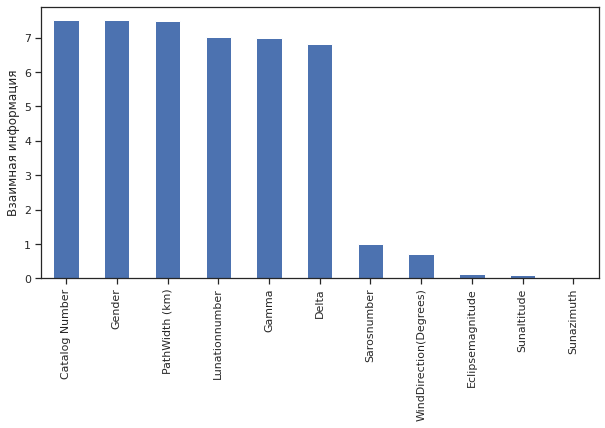

In [ ]:
mi = mutual_info_regression(x, y)
mi = pd.Series(mi)
mi.index = x.columns
mi.sort_values(ascending=False).plot.bar(figsize=(10,5))
plt.ylabel('Взаимная информация')

In [ ]:
sel_mi = SelectKBest(mutual_info_regression, k=5).fit(x, y)

list(zip(x.columns, sel_mi.get_support()))

[('Catalog Number', True),
 ('Delta', False),
 ('Lunationnumber', True),
 ('Sarosnumber', False),
 ('Gamma', True),
 ('Eclipsemagnitude', False),
 ('Sunaltitude', False),
 ('Sunazimuth', False),
 ('PathWidth (km)', True),
 ('WindDirection(Degrees)', False),
 ('Gender', True)]

# **Метод обертывания**
# **Алгоритм полного перебора**

In [ ]:
!pip install mlxtend

In [ ]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

knn = KNeighborsClassifier(n_neighbors=3)

In [ ]:
!pip install joblib

In [ ]:
efs1 = EFS(knn, 
           min_features=3,
           max_features=4,
           scoring='accuracy',
           print_progress=True,
           cv=5)

efs1 = efs1.fit(x, y, custom_feature_names = x.columns)

print('Best accuracy score: %.2f' % efs1.best_score_)
print('Best subset (indices):', efs1.best_idx_)
print('Best subset (corresponding names):', efs1.best_feature_names_)

ValueError: ignored

# New Section